In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision
from torchvision import transforms
import os

import glob
from PIL import Image

import pdb

In [80]:
torch.__version__

'1.9.1'

In [81]:
BATCH_SIZE = 8

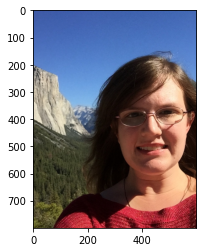

In [82]:
pil_img = Image.open(r'../input/unet-datasets/UNET_data/training/00001.png')
np_img = np.array(pil_img)
plt.imshow(np_img)
plt.show()

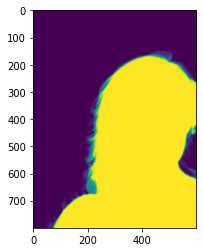

In [83]:
pil_img = Image.open(r'../input/unet-datasets/UNET_data/training/00001_matte.png')
np_img = np.array(pil_img)
plt.imshow(np_img)
plt.show()

In [84]:
# img蒙版上的像素
np.unique(np_img)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [85]:
# 这里有非常多像素，但我们希望蒙版上的像素只有两类
np_img.max(), np_img.min()

(255, 0)

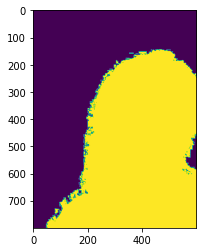

In [86]:
pil_img = Image.open(r'../input/unet-datasets/UNET_data/training/00001_matte.png')
np_img = np.array(pil_img)
np_img[np_img>0] = 1

plt.imshow(np_img)
plt.show()

In [87]:
# img蒙版上的像素:变成0和1
np.unique(np_img)

array([0, 1], dtype=uint8)

In [88]:
np_img.shape

(800, 600)

In [89]:
# glob.glob 获取所有图片的路径
all_pics = glob.glob('../input/unet-datasets/UNET_data/training/*.png')

In [90]:
all_pics[:5]

['../input/unet-datasets/UNET_data/training/01301.png',
 '../input/unet-datasets/UNET_data/training/00929.png',
 '../input/unet-datasets/UNET_data/training/00690_matte.png',
 '../input/unet-datasets/UNET_data/training/00704.png',
 '../input/unet-datasets/UNET_data/training/01124.png']

In [91]:
# 把matter和原图区分开: not matte
images = [p for p in all_pics if 'matte' not in p]
images[:3]
print("len images", len(images))

len images 1700


In [92]:
# matte
annotations = [p for p in all_pics if 'matte' in p]
annotations[:3]
print("len annotation", len(annotations))

len annotation 1700


In [93]:
images[-3:]

['../input/unet-datasets/UNET_data/training/01474.png',
 '../input/unet-datasets/UNET_data/training/00291.png',
 '../input/unet-datasets/UNET_data/training/01632.png']

In [94]:
annotations[-3:]

['../input/unet-datasets/UNET_data/training/00097_matte.png',
 '../input/unet-datasets/UNET_data/training/01678_matte.png',
 '../input/unet-datasets/UNET_data/training/00545_matte.png']

In [95]:
# 乱序seed
np.random.seed(2021)
# 创建乱序的index：随机打乱
index = np.random.permutation(len(images))
print(index)

[ 371 1289   62 ...   57 1365 1140]


In [96]:
# 乱序images
images = np.array(images)[index]
# 乱序annotation：
anno = np.array(annotations)[index]

In [97]:
anno[:5]

array(['../input/unet-datasets/UNET_data/training/00318_matte.png',
       '../input/unet-datasets/UNET_data/training/00533_matte.png',
       '../input/unet-datasets/UNET_data/training/00263_matte.png',
       '../input/unet-datasets/UNET_data/training/01114_matte.png',
       '../input/unet-datasets/UNET_data/training/01017_matte.png'],
      dtype='<U57')

In [98]:
# test数据：
all_test_pics = glob.glob(r'../input/unet-datasets/UNET_data/testing/*.png')

In [99]:
# 区分images 和 matte（annotation）
test_images = [p for p in all_test_pics if 'matte' not in p]
test_anno = [p for p in all_test_pics if 'matte' in p]

In [100]:
# transforms:
# 1.resize
# 2.Totensor

transform = transforms.Compose([
                    transforms.Resize((256, 256)),
                    transforms.ToTensor(),
])

In [101]:
class hk_datasets(data.Dataset):
    def __init__(self, imgs_path, annos_path):
        self.imgs_path = imgs_path
        self.annos_path = annos_path
        
    
    def __getitem__(self, index):
        # 切片
        img = self.imgs_path[index]
        anno = self.annos_path[index]
        
        # 读取,并transform, 转换为tensor
        pil_img = Image.open(img)
        img_tensor = transform(pil_img)
        
        anno_img = Image.open(anno)
        anno_tensor = transform(anno_img)
        
        # 把matte划分为0和1：256*256*1
        anno_tensor[anno_tensor > 0] = 1  
        # 去掉为1的维度：(转为类型.type)
        # 在pytorch中，习惯用 torch.long 表示整形(int 32)
        anno_tensor = torch.squeeze(anno_tensor).type(torch.long)
        
        return img_tensor, anno_tensor
    
    def __len__(self):
        return len(self.imgs_path)
        
        

In [102]:
# 创建类：
# train_dataset
train_dataset = hk_datasets(images, anno)
# test_dataset
test_dataset = hk_datasets(test_images, test_anno)

In [103]:
# 创建 train dataloader：train_dl
BATCH_SIZE = 8

train_dl = data.DataLoader(
                           train_dataset,
                           batch_size=BATCH_SIZE,
                           shuffle=True,
                        )

# test loader：test_dl
test_dl = data.DataLoader(
                          test_dataset,
                          batch_size=BATCH_SIZE,
                        )

In [104]:
# 创建batch数据：
# imgs_batch.shape: [bz, channel, H, W] = [8, 3, 256, 256] 
# annos_batch.shape: [bz, channel, H, W] = [8, 1, 256, 256] 
imgs_batch, annos_batch = next(iter(train_dl))
print('imgs_batch size:',imgs_batch.shape)
# 用了squeeze
print('annos_batch size:',annos_batch.shape)  

imgs_batch size: torch.Size([8, 3, 256, 256])
annos_batch size: torch.Size([8, 256, 256])


In [105]:
# 第一个batch取0，permute把维度调换，变为[H, W, channel], 并变成ndarray形式
img = imgs_batch[0].permute(1,2,0).numpy()
# anno本来就没有channel，那就直接取bz[0]，然后转为ndarray
anno = annos_batch[0].numpy()

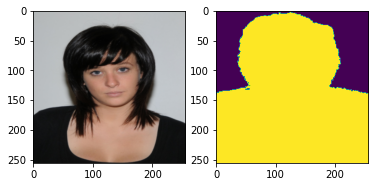

In [106]:
# plot
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(anno)

# Unet网络结构：

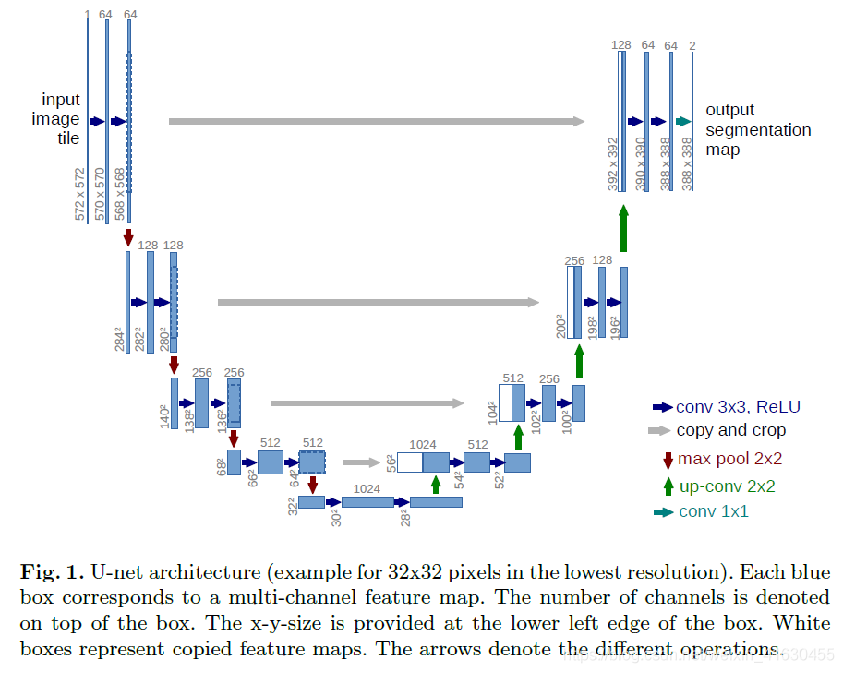

In [107]:
# 定义downsample子模型：封装 down-conv-conv
class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample, self).__init__()
        # 封装2层conv
        self.conv_relu = nn.Sequential(
                            # 第一层卷积
                            nn.Conv2d(in_channels, out_channels, 
                                      kernel_size=3, padding=1),
                            nn.ReLU(inplace=True),
                            # 第二层卷积，输入输出不变
                            nn.Conv2d(out_channels, out_channels, 
                                      kernel_size=3, padding=1),
                            nn.ReLU(inplace=True)
            )
        # downsample
        self.pool = nn.MaxPool2d(kernel_size=2)
    
    def forward(self, x, is_pool=True):
        # 如果存在pool(每个模块：down-conv-conv)
        if is_pool:
            x = self.pool(x)
        x = self.conv_relu(x)
        return x

In [108]:
# upsample：封装：conv-conv-upsample
class Upsample(nn.Module):
    def __init__(self, channels):
        super(Upsample, self).__init__()
        
        # 封装2层conv
        self.conv_relu = nn.Sequential(
                        nn.Conv2d(2*channels, channels, 
                                  kernel_size=3, padding=1),
                        # inplace = true意思是，用relu后的数据直接覆盖原数据
                        nn.ReLU(inplace=True),
                        nn.Conv2d(channels, channels,  
                                  kernel_size=3, padding=1),
                        nn.ReLU(inplace=True)
            )
        
        # upsample
        self.upconv_relu = nn.Sequential( 
                               nn.ConvTranspose2d(channels, 
                                                  channels//2, 
                                                  kernel_size=3,
                                                  stride=2,
                                                  padding=1,
                                                  output_padding=1),
                               nn.ReLU(inplace=True)
            )
        
    def forward(self, x):
#         pdb.set_trace()
        x = self.conv_relu(x)
        x = self.upconv_relu(x)
        return x

In [109]:
import pdb


class Unet_model(nn.Module):
    def __init__(self):
        super(Unet_model, self).__init__()
#         pdb.set_trace()
        # 5个 downsample： [in_channel, out_channel]
        self.down1 = Downsample(3, 64)  # 第一步没有pool
        self.down2 = Downsample(64, 128)
        self.down3 = Downsample(128, 256)
        self.down4 = Downsample(256, 512)
        self.down5 = Downsample(512, 1024)
        
        # 1 Upsample（这是结构图最底部变成upsample的部分）
        self.up = nn.Sequential(
                               nn.ConvTranspose2d(
                                          1024, 
                                          512, # out = channels//2
                                          kernel_size=3,
                                          stride=2, # 图像放大为原来两倍
                                          padding=1,
                                          output_padding=1),
                               nn.ReLU(inplace=True)
            )
        
        # 3个upsample
        self.up1 = Upsample(512)
        self.up2 = Upsample(256)
        self.up3 = Upsample(128)
        
        # 最后两层卷积：
        self.conv_2 = Downsample(128, 64)
        self.last = nn.Conv2d(64, 2, kernel_size=1)

        
    def forward(self, x):
        # 调用down1时，声明is_pool=False
        x1 = self.down1(x, is_pool=False)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.down5(x4)
        
        x5 = self.up(x5)
        # concat 能充分利用中间特征
        # concat dim=1，沿着channel合并
        x5 = torch.cat([x4, x5], dim=1)           # 32*32*1024
        
        x5 = self.up1(x5)                         # 64*64*256
        x5 = torch.cat([x3, x5], dim=1)           # 64*64*512  
        
        x5 = self.up2(x5)                         # 128*128*128
        x5 = torch.cat([x2, x5], dim=1)           # 128*128*256
        
        x5 = self.up3(x5)                         # 256*256*64
        x5 = torch.cat([x1, x5], dim=1)           # 256*256*128
        
        # 最后两层卷积：
        x5 = self.conv_2(x5, is_pool=False)       # 256*256*64
        x5 = self.last(x5)                        # 256*256*3
        return x5

输出结果：<br>
每一个像素点都输出一个长度为2的向量，来标记该向量属于第一类还是第二类

### Model

In [110]:
# 给模型初始化
model = Unet_model()
# model

In [111]:
if torch.cuda.is_available():
    model.to('cuda')

### Loss & optimizer

In [112]:
# loss：因为输出是一个2维向量（对二分类问题）
loss_fn = nn.CrossEntropyLoss()

In [113]:
# optimizier
from torch.optim import lr_scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# lr优化器：每经过7步，衰减0.1
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [114]:
# 训练函数：fit
def fit(epoch, model, trainloader, testloader):
    correct = 0
    total = 0
    running_loss = 0
    
    model.train()
    for x, y in trainloader:
        if torch.cuda.is_available():
            x, y = x.to('cuda'), y.to('cuda')
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
    
    exp_lr_scheduler.step()
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / (total*256*256)
        
        
    test_correct = 0
    test_total = 0
    test_running_loss = 0 
    
    # model.eval() 作用等同于 self.train(False)
    model.eval()
    # 被with torch.no_grad()包住的代码，不用跟踪反向梯度计算
    with torch.no_grad():
        for x, y in testloader:
            if torch.cuda.is_available():
                x, y = x.to('cuda'), y.to('cuda')
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset)
    epoch_test_acc = test_correct / (test_total*256*256)
    
        
    print('epoch: ', epoch, 
          'loss： ', round(epoch_loss, 3),
          'accuracy:', round(epoch_acc, 3),
          'test_loss： ', round(epoch_test_loss, 3),
          'test_accuracy:', round(epoch_test_acc, 3)
             )
        
    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

In [115]:
epochs = 2

In [116]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []
# ----- start training ------
for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch,
                                                                 model,
                                                                 train_dl,
                                                                 test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  0 loss：  0.078 accuracy: 0.663 test_loss：  0.077 test_accuracy: 0.684
epoch:  1 loss：  0.062 accuracy: 0.762 test_loss：  0.053 test_accuracy: 0.813


# 保存模型

In [120]:
# 保存训练好的权重信息
PATH = 'unet_model.pth'
torch.save(model.state_dict(), PATH)

# 测试模型（在test上测试）

In [122]:
# 新实例化一个model：
my_model = Unet_model()

# 加载出之前保存的 训练权重
my_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [123]:
# 先预测3张图片
num=3

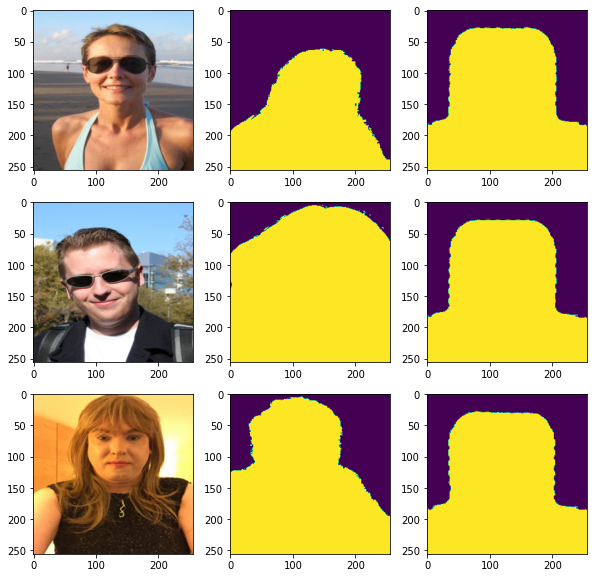

In [124]:
# 从test_dl中取数据
image_batch, mask_batch = next(iter(test_dl))

# 用训练好的模型 my_model 来训练test中的一个batch
pred_mask = my_model(image_batch)

plt.figure(figsize=(10, 10))
for i in range(num):
    plt.subplot(num, 3, i*num+1) # 3行3列第一个
    # 原图：channel在后面，所以要用permute
    plt.imshow(image_batch[i].permute(1,2,0).cpu().numpy())
    
    # 给定的真实mask：不用permute修改
    plt.subplot(num, 3, i*num+2)
    plt.imshow(mask_batch[i].cpu().numpy())
    
    # 预测结果 mask：
    plt.subplot(num, 3, i*num+3)
    # 1.argmax取预测结果最大对应的结果。2.要用permute
    # 已经确定 my_tensor.detach().numpy() 是从 torch 张量获取 numpy 数组的正确方法.
    plt.imshow(torch.argmax(pred_mask[i].permute(1,2,0), axis=-1).detach().numpy())

# 在train上测试

In [ ]:
image, mask = next(iter(train_dl))
pred_mask = my_model(image)

plt.figure(figsize=(10, 10))
for i in range(num):
    plt.subplot(num, 3, i*num+1)
    plt.imshow(image[i].permute(1,2,0).cpu().numpy())
    plt.subplot(num, 3, i*num+2)
    plt.imshow(mask[i].cpu().numpy())
    plt.subplot(num, 3, i*num+3)
    plt.imshow(torch.argmax(pred_mask[i].permute(1,2,0), axis=-1).detach().numpy())

In [164]:
# 创建一个新模型示例
model_test = Unet_model()

path = '../input/img001/img01.png'
test_img01 = Image.open(path)
img_tensor = transform(test_img01)
img_tensor.shape

torch.Size([3, 256, 256])

In [165]:
# 要添加bz维度:[1,3,256,256], 添加到第0维度
img_tensor_batch = torch.unsqueeze(img_tensor,0)
img_tensor_batch.shape

torch.Size([1, 3, 256, 256])

In [179]:
pred = model_test(img_tensor_batch)
# torch.Size([1, 2, 256, 256]) （channel=2） 输出为0或1 
pred.shape
# plt.imshow(pred.detach().numpy())

torch.Size([1, 2, 256, 256])

In [180]:
pred = torch.argmax(pred[0].permute(1,2,0), axis=-1).numpy()

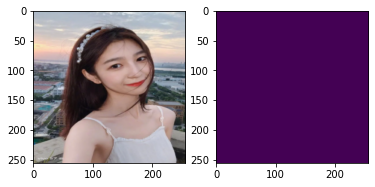

In [182]:
plt.subplot(1,2,1)
plt.imshow(img_tensor.permute(1,2,0).numpy())
plt.subplot(1,2,2)
plt.imshow(pred)